In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install tensorflow keras numpy opencv-python-headless lxml

import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_data(images_path, annotations_path):
    data = []
    for filename in os.listdir(images_path):
        if filename.endswith(".jpg"):
            image_path = os.path.join(images_path, filename)
            annotation_path = os.path.join(annotations_path, filename.replace(".jpg", ".xml"))

            if os.path.exists(annotation_path) and os.path.getsize(annotation_path) > 0:
                try:
                    tree = ET.parse(annotation_path)
                    boxes = []

                    for obj in tree.findall('object'):
                        bbox = obj.find('bndbox')
                        xmin = int(float(bbox.find('xmin').text))
                        ymin = int(float(bbox.find('ymin').text))
                        xmax = int(float(bbox.find('xmax').text))
                        ymax = int(float(bbox.find('ymax').text))
                        class_name = obj.find('name').text
                        boxes.append((xmin, ymin, xmax, ymax, class_name))

                    image = cv2.imread(image_path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    if image is not None and boxes:
                        data.append((image, boxes))
                except ET.ParseError as e:
                    print(f"Error parsing {annotation_path}: {e}")
            else:
                print(f"Skipping missing or empty file: {annotation_path}")
    return data

In [ ]:
from sklearn.model_selection import train_test_split

# Load data
data = load_data('/content/drive/MyDrive/Capstone/Data/Version1/normalized_images',
                 '/content/drive/MyDrive/Capstone/Data/Version1/resized_annotations')

# Prepare data for model
X = [x[0] for x in data]  # image data
y = [x[1] for x in data]  # annotations

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


Skipping missing or empty file: /content/drive/MyDrive/Capstone/Data/Version1/resized_annotations/frame_208.xml


In [ ]:
def create_rcnn(num_classes):
    base_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    x = keras.layers.Flatten()(base_model.output)
    x = keras.layers.Dense(4096, activation='relu')(x)
    x = keras.layers.Dense(4096, activation='relu')(x)

    class_output = keras.layers.Dense(num_classes, activation='softmax', name='class_output')(x)
    bbox_output = keras.layers.Dense(4, name='bbox_output')(x)

    model = keras.Model(inputs=base_model.input, outputs=[class_output, bbox_output])
    return model

In [ ]:
# Get unique class names
class_names = set()
for boxes in y:
    for box in boxes:
        class_names.add(box[4])
num_classes = len(class_names)
class_to_index = {cls: idx for idx, cls in enumerate(class_names)}

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

rcnn_model = create_rcnn(num_classes)

NameError: name 'y' is not defined

In [ ]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, images, boxes, batch_size=32, dim=(224, 224), n_channels=3, n_classes=num_classes, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.images = images
        self.boxes = boxes
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.images))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        X, y_class, y_bbox = self.__data_generation(indexes)
        return X, {'class_output': y_class, 'bbox_output': y_bbox}

    def __data_generation(self, indexes):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y_class = np.zeros((self.batch_size, self.n_classes))
        y_bbox = np.zeros((self.batch_size, 4))

        for i, idx in enumerate(indexes):
            img = cv2.resize(self.images[idx], self.dim)
            X[i,] = img / 255.0

            if self.boxes[idx]:
                box = self.boxes[idx][0]  # Take the first box for simplicity
                y_class[i, class_to_index[box[4]]] = 1
                y_bbox[i] = [box[0]/self.dim[0], box[1]/self.dim[1], box[2]/self.dim[0], box[3]/self.dim[1]]

        return X, y_class, y_bbox

In [ ]:
# Create data generators
train_generator = DataGenerator(X_train, y_train, batch_size=16)
validation_generator = DataGenerator(X_val, y_val, batch_size=16)

# Compile the model
rcnn_model.compile(
    optimizer='adam',
    loss={
        'class_output': keras.losses.CategoricalCrossentropy(),
        'bbox_output': keras.losses.MeanSquaredError()
    },
    loss_weights={
        'class_output': 1.0,
        'bbox_output': 1.0
    },
    metrics={
        'class_output': keras.metrics.CategoricalAccuracy(name='accuracy')
    }
)

In [ ]:
# Train the model
history = rcnn_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20
)

# Save the model
rcnn_model.save('/content/drive/MyDrive/Capstone/rcnn_model2.h5')

Epoch 1/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 45s 271ms/step - class_output_accuracy: 0.4992 - loss: 1.6142 - val_class_output_accuracy: 0.4527 - val_loss: 1.7540
Epoch 2/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 46s 281ms/step - class_output_accuracy: 0.4846 - loss: 1.6509 - val_class_output_accuracy: 0.5152 - val_loss: 1.5513
Epoch 3/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 82s 280ms/step - class_output_accuracy: 0.5250 - loss: 1.4914 - val_class_output_accuracy: 0.4207 - val_loss: 2.1715
Epoch 4/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 46s 279ms/step - class_output_accuracy: 0.4037 - loss: 2.0514 - val_class_output_accuracy: 0.4253 - val_loss: 2.0473
Epoch 5/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 82s 279ms/step - class_output_accuracy: 0.4261 - loss: 1.9471 - val_class_output_accuracy: 0.4741 - val_loss: 1.7477
Epoch 6/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 46s 278ms/step - class_output_accuracy: 0.4937 - loss: 1.5934 - val_class_output_accuracy: 0.4954 - val_loss: 1.5297
Epoch 7/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 46s 282ms/step - c

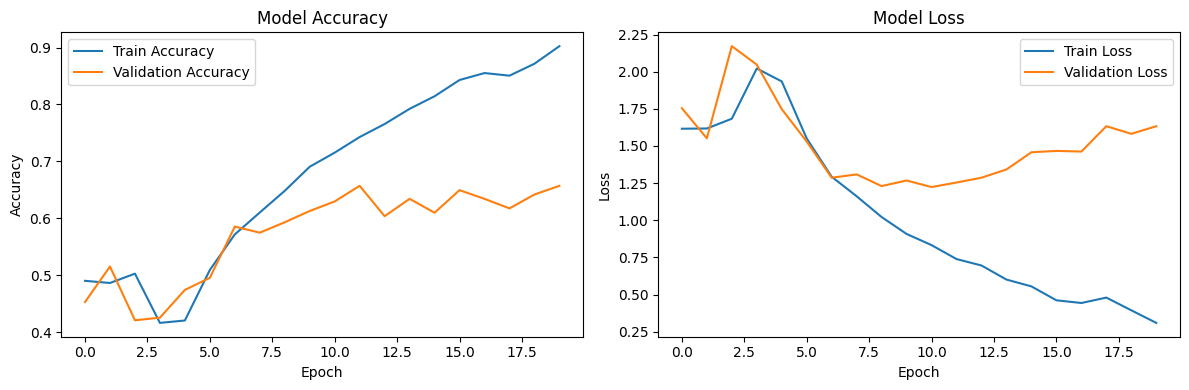

In [ ]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['class_output_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_class_output_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()